In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


# tree

├── mask-rcnn-coco  
│   ├── colors.txt  
│   ├── frozen_inference_graph.pb  
│   ├── mask_rcnn_inception_v2_coco_2018_01_28.pbtxt  
│   └── object_detection_classes_coco.txt  
├── images  
│   ├── example_01.jpg  
│   ├── example_02.jpg  
│   └── example_03.jpg  
├── videos  
│   ├──   
├── output  
│   ├──    
├── mask_rcnn.py  
└── mask_rcnn_video.py  

In [ ]:
! pip install gdown

In [ ]:
! gdown --id 12gmZStQajv6hJK5zAMxh1XI5Ut6vQ8GX

Downloading...
From: https://drive.google.com/uc?id=12gmZStQajv6hJK5zAMxh1XI5Ut6vQ8GX
To: /content/mask-rcnn.zip
59.7MB [00:00, 96.5MB/s]


In [ ]:
!unzip mask-rcnn.zip

Archive:  mask-rcnn.zip
  inflating: mask-rcnn/images/advanced2 (17).jpg  
  inflating: mask-rcnn/images/CR_normal (7).jpg  
  inflating: mask-rcnn/images/example_01.jpg  
  inflating: mask-rcnn/images/example_02.jpg  
  inflating: mask-rcnn/images/example_03.jpg  
  inflating: mask-rcnn/mask-rcnn-coco/colors.txt  
  inflating: mask-rcnn/mask-rcnn-coco/frozen_inference_graph.pb  
  inflating: mask-rcnn/mask-rcnn-coco/mask_rcnn_inception_v2_coco_2018_01_28.pbtxt  
  inflating: mask-rcnn/mask-rcnn-coco/object_detection_classes_coco.txt  
  inflating: mask-rcnn/mask_rcnn.py  
  inflating: mask-rcnn/mask_rcnn_video.py  
   creating: mask-rcnn/output/
   creating: mask-rcnn/videos/


In [ ]:
!pwd
!ls -al

/content
total 58296
drwxr-xr-x 1 root root     4096 Oct  4 07:08 .
drwxr-xr-x 1 root root     4096 Oct  4 07:07 ..
drwxr-xr-x 1 root root     4096 Oct  1 16:28 .config
drwxr-xr-x 6 root root     4096 Oct  4 07:08 mask-rcnn
-rw-r--r-- 1 root root 59667981 Oct  4 07:08 mask-rcnn.zip
drwxr-xr-x 1 root root     4096 Oct  1 16:28 sample_data


# import the necessary packages

In [ ]:

import numpy as np
import argparse
import random
import time
import cv2
import os
from google.colab.patches import cv2_imshow


# construct the argument parse and parse the arguments

1. image : The path to our input image.  
2.mask-rnn : The base path to the Mask R-CNN files.  
3.visualize  (optional): A positive value indicates that we want to visualize how we extracted the masked region on our screen. Either way, we’ll display the final output on the screen.  
4.confidence  (optional): You can override the probability value of 0.5  which serves to filter weak detections.  
5.threshold  (optional): We’ll be creating a binary mask for each object in the image and this threshold value will help us filter out weak mask predictions. I found that a default value of 0.3  works pretty well.

In [ ]:

# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--image", required=True,
#   help="path to input image")
# ap.add_argument("-m", "--mask-rcnn", required=True,
# 	help="base path to mask-rcnn directory")
# ap.add_argument("-v", "--visualize", type=int, default=0,
# 	help="whether or not we are going to visualize each instance")
# ap.add_argument("-c", "--confidence", type=float, default=0.5,
# 	help="minimum probability to filter weak detections")
# ap.add_argument("-t", "--threshold", type=float, default=0.3,
# 	help="minimum threshold for pixel-wise mask segmentation")
# args = vars(ap.parse_args())

In [ ]:
args = { "image":"/content/mask-rcnn/images/example_02.jpg", 
        "image2":"/content/mask-rcnn/images/CR_normal (7).jpg",
        "mask_rcnn":"/content/mask-rcnn/mask-rcnn-coco",
        "visualize":0,
        "confidence":0.5,
       "threshold":0.3 }

# Load our labels and colors

In [ ]:
#load the COCO class labels our Mask R-CNN was trained on
labelsPath = os.path.sep.join([args["mask_rcnn"],
	"object_detection_classes_coco.txt"])
LABELS = open(labelsPath).read().strip().split("\n")

In [ ]:
# load the set of colors that will be used when visualizing a given
# instance segmentation
colorsPath = os.path.sep.join([args["mask_rcnn"], "colors.txt"])
COLORS = open(colorsPath).read().strip().split("\n")
COLORS = [np.array(c.split(",")).astype("int") for c in COLORS]
COLORS = np.array(COLORS, dtype="uint8")

# load Mask R-CNN trained on the COCO dataset (90 classes)

In [ ]:


# derive the paths to the Mask R-CNN weights and model configuration
weightsPath = os.path.sep.join([args["mask_rcnn"],
	"frozen_inference_graph.pb"])
configPath = os.path.sep.join([args["mask_rcnn"],
	"mask_rcnn_inception_v2_coco_2018_01_28.pbtxt"])

In [ ]:
# from disk
print("[INFO] loading Mask R-CNN from disk...")
net = cv2.dnn.readNetFromTensorflow(weightsPath, configPath)

[INFO] loading Mask R-CNN from disk...


# load our input image and grab its spatial dimensions

In [ ]:
image = cv2.imread(args["image"])
#image = cv2.imread(args["image2"])
(H, W) = image.shape[:2]

In [ ]:
# construct a blob from the input image and then perform a forward
# pass of the Mask R-CNN, giving us (1) the bounding box  coordinates
# of the objects in the image along with (2) the pixel-wise segmentation
# for each specific object
blob = cv2.dnn.blobFromImage(image, swapRB=True, crop=False)
net.setInput(blob)
start = time.time()
(boxes, masks) = net.forward(["detection_out_final", "detection_masks"])
end = time.time()

In [ ]:
# show timing information and volume information on Mask R-CNN
print("[INFO] Mask R-CNN took {:.6f} seconds".format(end - start))
print("[INFO] boxes shape: {}".format(boxes.shape))
print("[INFO] masks shape: {}".format(masks.shape))

[INFO] Mask R-CNN took 5.220680 seconds
[INFO] boxes shape: (1, 1, 100, 7)
[INFO] masks shape: (100, 90, 15, 15)


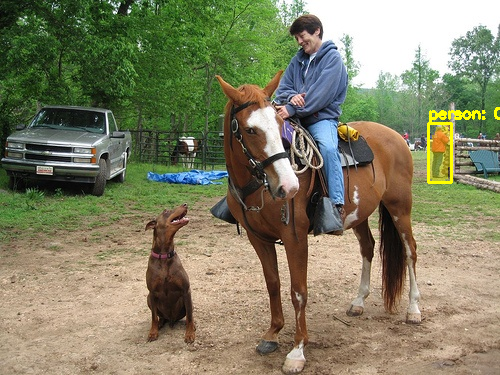

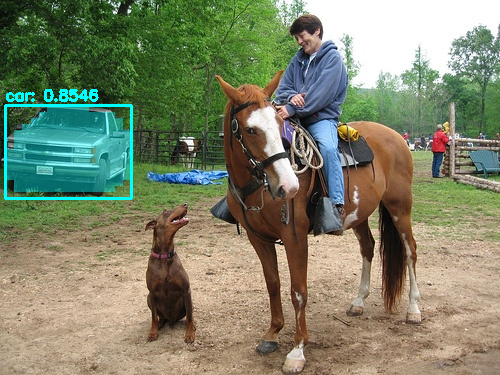

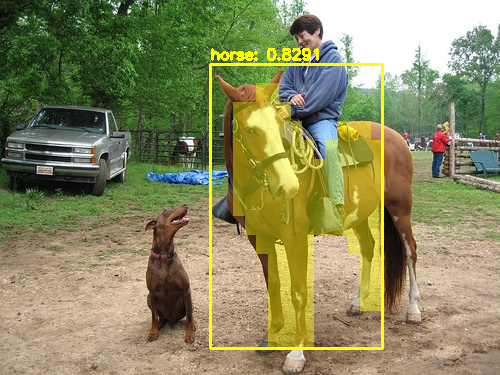

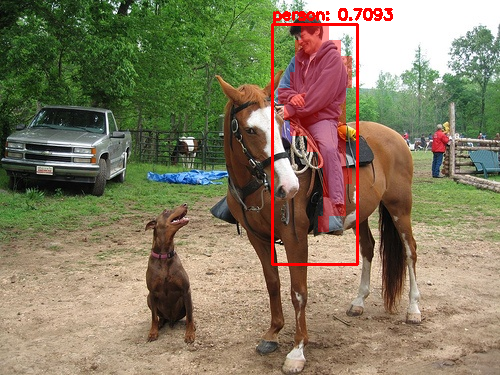

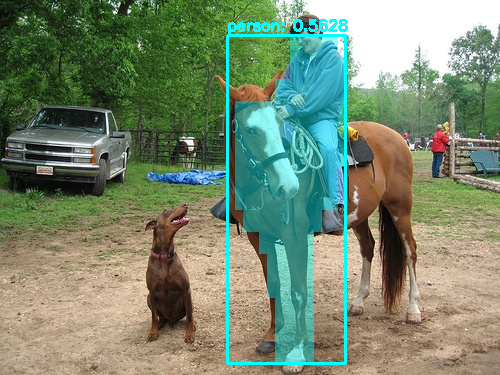

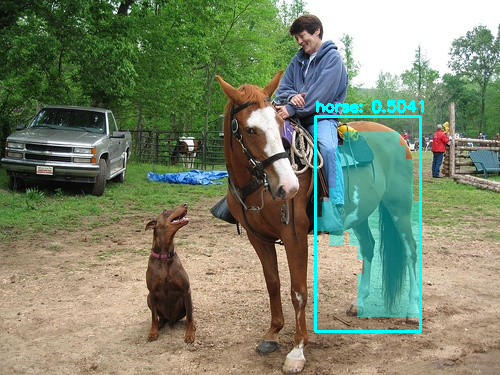

In [ ]:
# loop over the number of detected objects
for i in range(0, boxes.shape[2]):
	# extract the class ID of the detection along with the confidence
	# (i.e., probability) associated with the prediction
	classID = int(boxes[0, 0, i, 1])
	confidence = boxes[0, 0, i, 2]

	# filter out weak predictions by ensuring the detected probability
	# is greater than the minimum probability
	if confidence > args["confidence"]:
		# clone our original image so we can draw on it
		clone = image.copy()

		# scale the bounding box coordinates back relative to the
		# size of the image and then compute the width and the height
		# of the bounding box
		box = boxes[0, 0, i, 3:7] * np.array([W, H, W, H])
		(startX, startY, endX, endY) = box.astype("int")
		boxW = endX - startX
		boxH = endY - startY

		# extract the pixel-wise segmentation for the object, resize
		# the mask such that it's the same dimensions of the bounding
		# box, and then finally threshold to create a *binary* mask
		mask = masks[i, classID]
		mask = cv2.resize(mask, (boxW, boxH),
			interpolation=cv2.INTER_NEAREST)
		mask = (mask > args["threshold"])

		# extract the ROI of the image
		roi = clone[startY:endY, startX:endX]

		# check to see if are going to visualize how to extract the
		# masked region itself
		if args["visualize"] > 0:
			# convert the mask from a boolean to an integer mask with
			# to values: 0 or 255, then apply the mask
			visMask = (mask * 255).astype("uint8")
			instance = cv2.bitwise_and(roi, roi, mask=visMask)

			# show the extracted ROI, the mask, along with the
			# segmented instance
			cv2_imshow("ROI", roi)
			cv2_imshow("Mask", visMask)
			cv2_imshow("Segmented", instance)

		# now, extract *only* the masked region of the ROI by passing
		# in the boolean mask array as our slice condition
		roi = roi[mask]

		# randomly select a color that will be used to visualize this
		# particular instance segmentation then create a transparent
		# overlay by blending the randomly selected color with the ROI
		color = random.choice(COLORS)
		blended = ((0.4 * color) + (0.6 * roi)).astype("uint8")

		# store the blended ROI in the original image
		clone[startY:endY, startX:endX][mask] = blended

		# draw the bounding box of the instance on the image
		color = [int(c) for c in color]
		cv2.rectangle(clone, (startX, startY), (endX, endY), color, 2)

		# draw the predicted label and associated probability of the
		# instance segmentation on the image
		text = "{}: {:.4f}".format(LABELS[classID], confidence)
		cv2.putText(clone, text, (startX, startY - 5),
			cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

		# show the output image
		cv2_imshow(clone)
		cv2.waitKey(0)